## Training a Semantic Segmentation model on the MaSTr1325 Dataset

### https://box.vicos.si/borja/viamaro/index.html#references

### Import relevent packages

In [1]:
import numpy as np
import random
import sys
import skimage.io
from PIL import Image
import cv2
#import segmentation_models as sm
import matplotlib.image as mpimg
import glob
from PIL import Image
import scipy.io as sio
import numpy
import glob
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow import keras


### Define helper functions from CAB420

In [2]:
def mask_to_categorical(im, num_classes):    
    one_hot_map = []
    for i in range(num_classes):
        class_map = tf.reduce_all(tf.equal(im, i+1), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)    
    return one_hot_map

def categorical_to_mask(im):
    mask = tf.dtypes.cast(tf.argmax(im, axis=2), 'float32') / 255.0
    return mask

def random_crop(img_x, img_y, random_crop_size):

    height, width = img_x.shape[0], img_x.shape[1]
    dy, dx = random_crop_size
    x = numpy.random.randint(0, width - dx + 1)
    y = numpy.random.randint(0, height - dy + 1)
    return img_x[y:(y+dy), x:(x+dx), :], img_y[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops_x = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        batch_crops_y = numpy.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops_x[i], batch_crops_y[i] = random_crop(batch_x[i], batch_y[i], (crop_length, crop_length))
        yield (batch_crops_x, mask_to_categorical(batch_crops_y, 5))
        
def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def create_callbacks():
    scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)
    return [scheduler_callback, early_stopping]

def create_optimiser():
    return tf.keras.optimizers.Adam()
steps_per_epoch = 100
epochs = 50

def visualise(model, test_data, test_gt):
    pred = model.predict(test_data)
    fig = plt.figure(figsize=[20, 25])
    for i,img in enumerate(test_data):
        if (i < 32):
            ax = fig.add_subplot(8, 8, i*2 + 1)
            ax.imshow(img)
            ax = fig.add_subplot(8, 8, i*2 + 2)
            ax.imshow(categorical_to_mask(pred[i,:,:,:]))  

### Import all the data

In [3]:
def load_files(path, target_size, scale_factor):    
    image_list = []
    filenames = glob.glob(path)
    filenames.sort()
    for filename in filenames:
        im = Image.open(filename)
        w, h = im.size
        im = im.resize((target_size, target_size))
        im=numpy.asarray(im) / scale_factor
        image_list.append(im)
    return numpy.asarray(image_list)

### Define custom train and test data split

In [4]:
def train_test_split_custom(images, masks):

    train_images = []
    test_images = []
    train_masks = []
    test_masks = []

    iteration_check = 0

    for i in range(len(images)):

        if (iteration_check == 5):
            test_images.append(images[i])
            test_masks.append(masks[i])
            iteration_check = 0
        else:
            train_images.append(images[i])
            train_masks.append(masks[i])
            iteration_check += 1

    return train_images, test_images, train_masks, test_masks

### Load Data and run through split

In [28]:
images = load_files('./MaSTr1325_images/*',  128, 255.0)
masks = load_files('./MaSTr1325_masks/*', 128, 1.0)
masks = numpy.reshape(masks, (numpy.shape(masks) + (1, )))

train_images, test_images, train_masks, test_masks = train_test_split_custom(images, masks)

In [31]:
print(np.shape(train_images))
print(np.shape(test_images))
print(np.shape(train_masks))
print(np.shape(test_masks))

(1105, 128, 128, 3)
(220, 128, 128, 3)
(1105, 128, 128, 1)
(220, 128, 128, 1)


### Custom Labelled Data (not currently working)

In [7]:
# images_2 = load_files('./MODD_Dataset_Annotated/images/*', 128, 255.0)
# masks_2 = load_files('./MODD_Dataset_Annotated/masks/*', 128, 1.0)
#masks_2 = numpy.reshape(masks_2, (numpy.shape(masks_2) + (1, )))

# train_masks_2 = tf.keras.utils.to_categorical(masks_2, num_classes=None)
# train_masks_2 = train_masks_2[:,:,:,:4]


### Put masks into usable format

In [32]:
test_masks = tf.keras.utils.to_categorical(test_masks, num_classes=None)
train_masks = tf.keras.utils.to_categorical(train_masks, num_classes=None)

test_masks = test_masks[:,:,:,:4]
train_masks = train_masks[:,:,:,:4]

### Perform sanity check

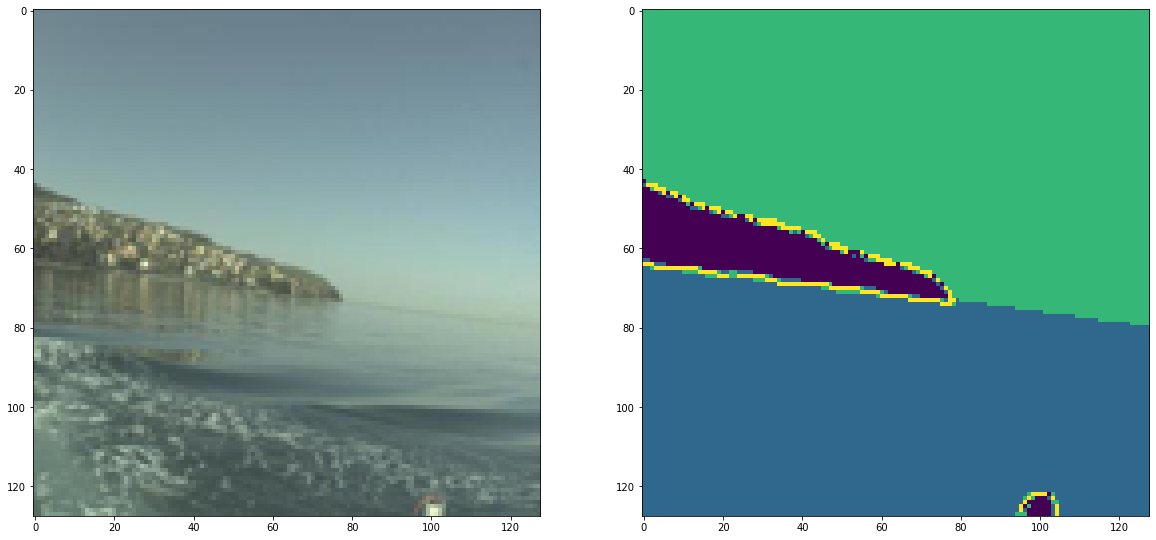

In [34]:
image_number = 10

fig = plt.figure(figsize=[20, 25])
ax = fig.add_subplot(1, 2, 1)
ax.imshow(train_images[image_number])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(categorical_to_mask(train_masks[image_number,:,:,:]))

In [12]:
# image_number = 1

# fig = plt.figure(figsize=[20, 25])
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(images_2[image_number])
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(categorical_to_mask(train_masks_2[image_number,:,:,:]))

### Define Custom Data Generator Function

In [39]:
def data_aug(images, masks):

    newTrainingImages = []
    newTrainingMasks = []

    for i in range(len(images)):
        
        sigma = random.random()

        blurred = skimage.filters.gaussian(images[i], sigma=(sigma, sigma), truncate=3.5, channel_axis=2)
        flipped = cv2.flip(images[i], 1)
        flipped_mask = cv2.flip(masks[i], 1)


        newTrainingImages.append(images[i])
        newTrainingMasks.append(masks[i])

        newTrainingImages.append(blurred)
        newTrainingMasks.append(masks[i])

        newTrainingImages.append(flipped)
        newTrainingMasks.append(flipped_mask)

    newTrainingImages = numpy.array(newTrainingImages)
    newTrainingMasks = numpy.array(newTrainingMasks)
    
    return newTrainingImages, newTrainingMasks

### Run data through augmentator 

In [40]:
train_images_augmented, train_masks_augmented = data_aug(train_images, train_masks)
test_images_augmented, test_masks_augmented = data_aug(test_images, test_masks)

In [ ]:
print(np.shape(train_images_augmented)
print(np.shape(train_images))
print(np.shape(train_masks_augmented))
print(np.shape(train_masks)

#### Create U-NET

In [41]:
input_img = Input(shape=(128, 128, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2), padding='same')(conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

up1 = UpSampling2D((2, 2))(conv4)
merge1 = concatenate([conv3,up1], axis = 3)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

up2 = UpSampling2D((2, 2))(conv5)
merge2 = concatenate([conv2,up2], axis = 3)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)

up3 = UpSampling2D((2, 2))(conv6)
merge3 = concatenate([conv1,up3], axis = 3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(merge3)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
decoded = Conv2D(4, (1, 1), activation='softmax', padding='same')(conv7)

unet = Model(input_img, decoded)
print(unet.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 128, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_60[0][0]']              
                                )                                                           

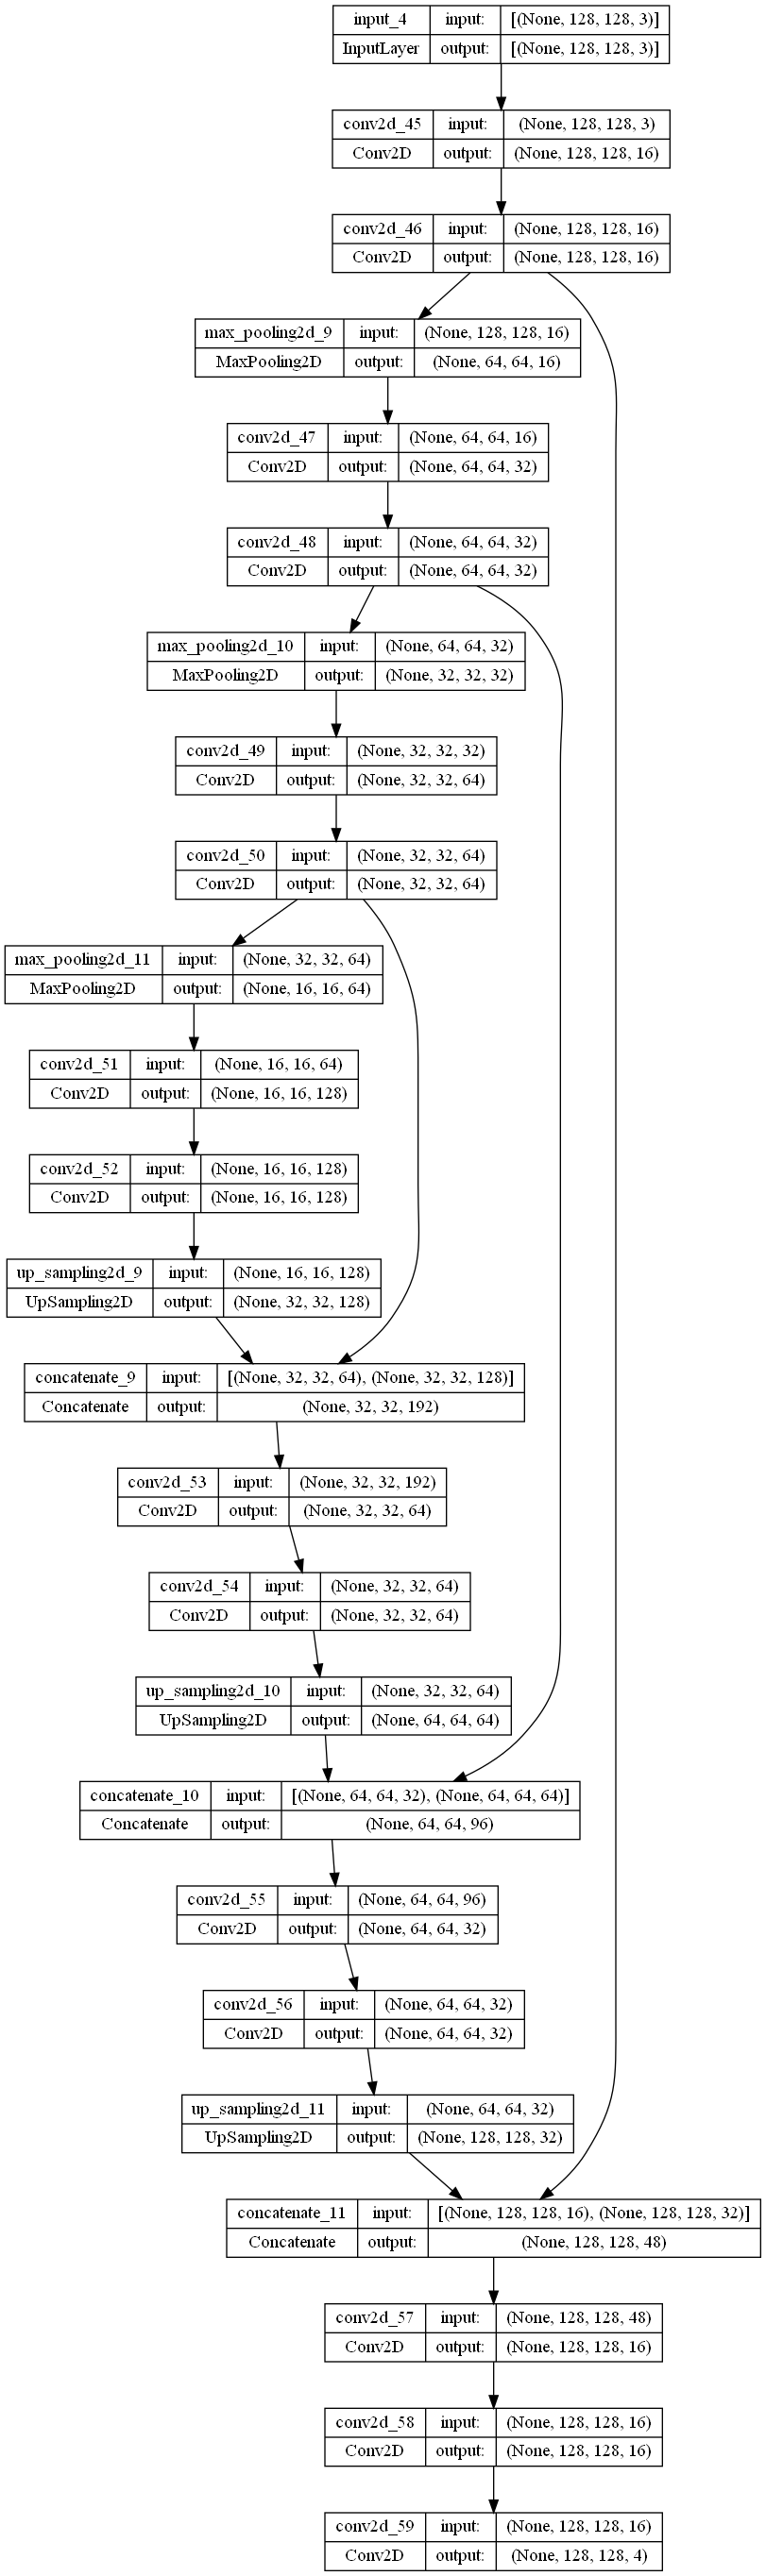

In [37]:
plot_model(unet, show_shapes=True)

### Train U-Net on training data

In [43]:
unet.compile(optimizer=create_optimiser(), loss=focal_loss)
unet.fit(train_images_augmented, train_masks_augmented, steps_per_epoch = 500, epochs = 100,
              validation_data= (test_images_augmented, test_masks_augmented), validation_steps = 10, callbacks=create_callbacks())

Epoch 1/100
500/500 [==============================] - 11s 19ms/step - loss: 0.0642 - val_loss: 0.0492 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0502 - val_loss: 0.0437 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0424 - val_loss: 0.0357 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0435 - val_loss: 0.0519 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0385 - val_loss: 0.0341 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0354 - val_loss: 0.0409 - lr: 0.0010
Epoch 7/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0328 - val_loss: 0.0316 - lr: 0.0010
Epoch 8/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0322 - val_loss: 0.0302 - lr: 0.0010
Epoch 9/100
500/500 [==============================] - 8s 16ms/step - loss: 0.0

#### Visualise results of U-Net

In [49]:
visualise(unet, test_images, test_masks)

ValueError: in user code:

    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_4" expects 1 input(s), but it received 220 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(32, 128, 3) dtype=float32>]


### Predict on Test Set

In [46]:
pred = unet.predict(test_images) #U-Net

ValueError: in user code:

    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\.conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_4" expects 1 input(s), but it received 220 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(32, 128, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(32, 128, 3) dtype=float32>]


### Visualise Results

In [ ]:
fig = plt.figure(figsize=[200, 250])

numberOfImages = 16
startingNum = 20
j = 0

for i in range(numberOfImages):
    ax = fig.add_subplot(8, 8, i*2 + 1)
    ax.imshow(test_images[startingNum + i])
    ax = fig.add_subplot(8, 8, i*2 + 2)
    ax.imshow(categorical_to_mask(pred[startingNum + i,:,:,:]))
    j += 5 

## Use these model on MODD Dataset

### Load in MODD Dataset

In [ ]:
images_MODD = load_files('./MODD_Dataset/*/images/*.jpg',  128, 255.0)

4454


### Run dataset against model

In [ ]:
pred2_MODD = unet.predict(images_MODD[2000:4000]) #U-Net

63/63 [==============================] - 1s 23ms/step


### Visualise Results

In [ ]:
fig = plt.figure(figsize=[200, 250])

numberOfImages = 16
startingNum = 20
j = 0

for i in range(numberOfImages):
    ax = fig.add_subplot(8, 8, i*2 + 1)
    ax.imshow(images_MODD[2000 + startingNum + i])
    ax = fig.add_subplot(8, 8, i*2 + 2)
    ax.imshow(categorical_to_mask(pred2_MODD[startingNum + i,:,:,:]))
    j += 5 